## Test task  
Research loan applications submitted to the bank.

### Importing Libraries and Dataset

In [65]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
from scipy.stats import pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [66]:
# create dataset
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSju4d1pL1fenyfDmTuE6yREJgCQFxX7YZht6w4xnsGo7K7ez4tdYZqEILRhYXSzvcVqpYoGSJu8RKq/pub?output=csv')
# and see the first rows
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [67]:
# let's look at the categorial and types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


The data has gaps, let's count them up

In [68]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [69]:
#Let's see a categorial breakdown of the data.
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Summarize
There is quite a lot of categorial data in the data, the omissions of which we will not be able to eliminate

### Prepare data

In [70]:
#We'll check for duplicates
data.drop_duplicates()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


### Prepare data Importing Libraries and Dataset  
Great, they're gone. If we cut all lines with gaps, we will lose about 22% of data. The only column that we can add is Loan_Amount_Term, since it has an absolute majority of the 360 period (to be further shown in the graph) and therefore we can fill it with the median value. We have to cut off the rest of the empty rows, as it hinders the correct operation of the correlation matrix and machine learning.

In [71]:
#find median vallue
data['Loan_Amount_Term'].median()

360.0

In [72]:
median_values = data['Loan_Amount_Term'].median()

# Fill in the missing values with the median values
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(median_values)

#cut empty
data= data.dropna()
#dummy variable for ml
data2=data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            492 non-null    object 
 1   Gender             492 non-null    object 
 2   Married            492 non-null    object 
 3   Dependents         492 non-null    object 
 4   Education          492 non-null    object 
 5   Self_Employed      492 non-null    object 
 6   ApplicantIncome    492 non-null    int64  
 7   CoapplicantIncome  492 non-null    float64
 8   LoanAmount         492 non-null    float64
 9   Loan_Amount_Term   492 non-null    float64
 10  Credit_History     492 non-null    float64
 11  Property_Area      492 non-null    object 
 12  Loan_Status        492 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 53.8+ KB


we have to part with 19% of the data, which is a significant number.

### Exploratory Data Analysis  
First, let's familiarize ourselves with the categorial variables and compare them with the key variable Loan_Status, since the purpose of a loan application is to get approval. For this purpose, we will plot the absolute value and comparison with the Yes or No categories of the key variable.

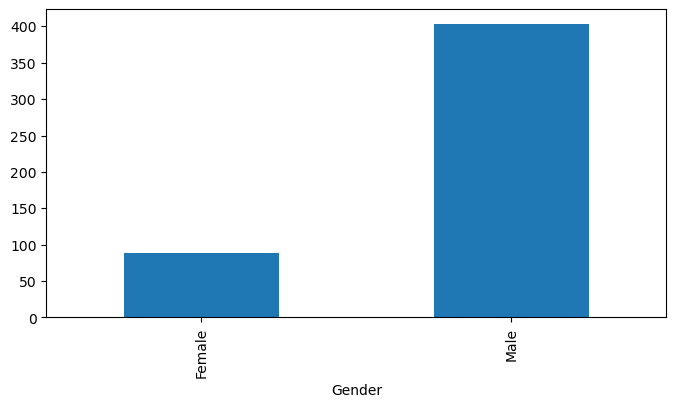

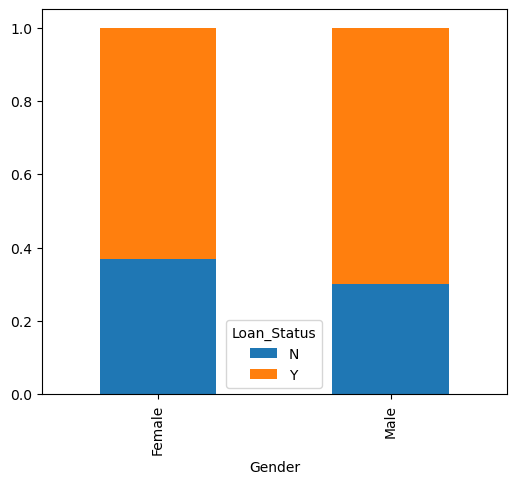

In [73]:
Gender = data.groupby('Gender')['Gender'].count()
Gender.plot(kind='bar', figsize=(8, 4))
Gender=pd.crosstab(data['Gender'],data['Loan_Status'])
Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

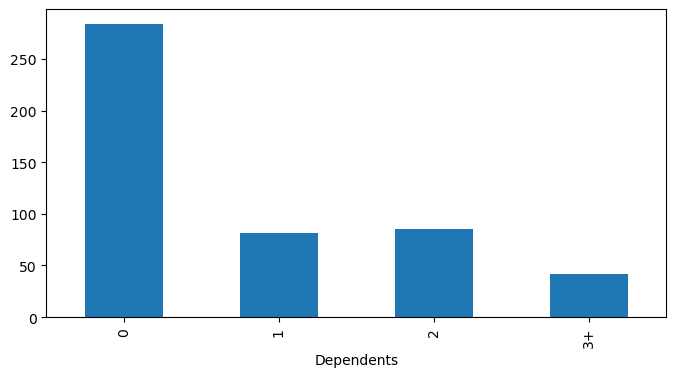

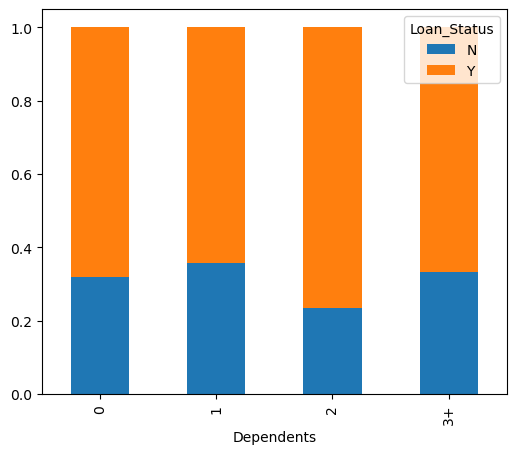

In [74]:
Dependents = data.groupby('Dependents')['Dependents'].count()
Dependents.plot(kind='bar', figsize=(8, 4))
Dependents=pd.crosstab(data['Dependents'],data['Loan_Status'])
Dependents.div(Dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

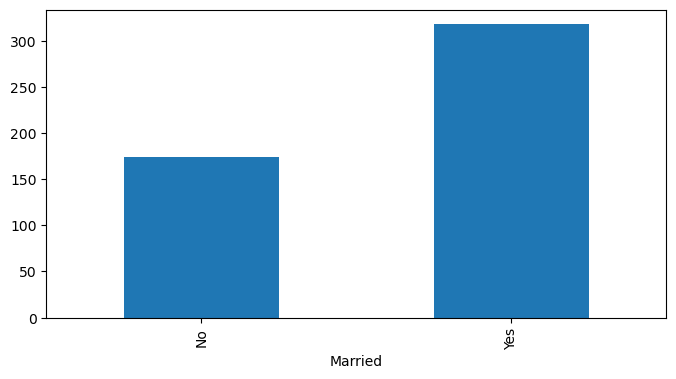

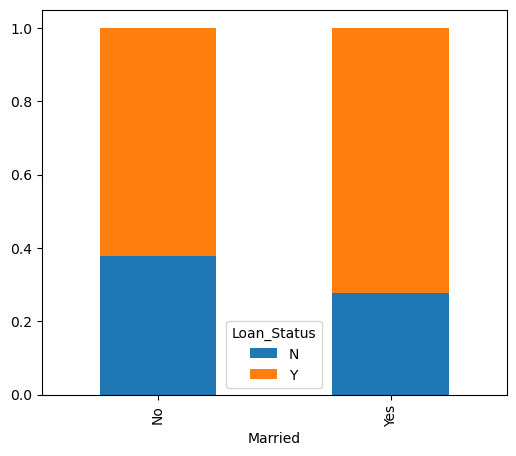

In [75]:
Married = data.groupby('Married')['Married'].count()
Married.plot(kind='bar', figsize=(8, 4))
Married=pd.crosstab(data['Married'],data['Loan_Status'])
Married.div(Married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

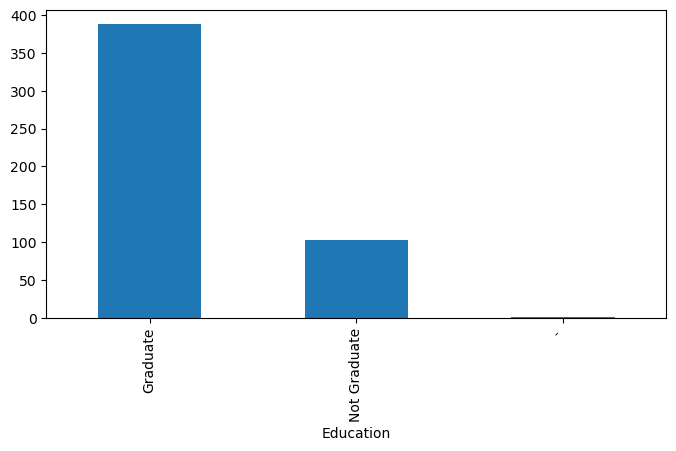

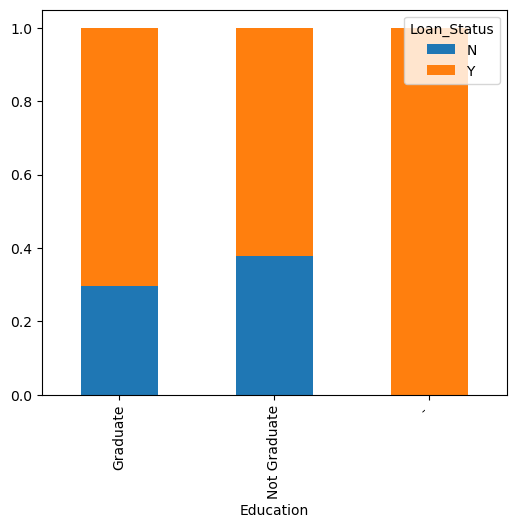

In [76]:
Education = data.groupby('Education')['Education'].count()
Education.plot(kind='bar', figsize=(8, 4))
Education=pd.crosstab(data['Education'],data['Loan_Status'])
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

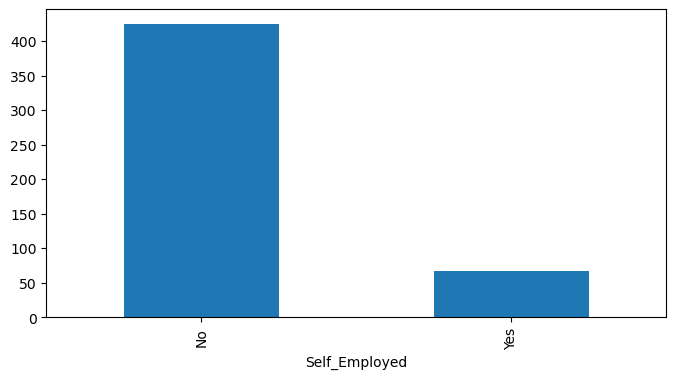

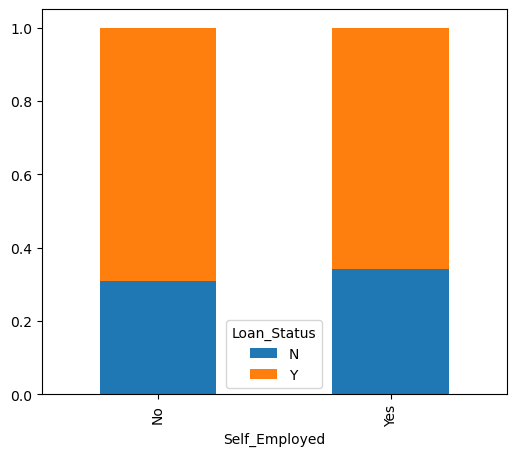

In [77]:
Self_Employed = data.groupby('Self_Employed')['Self_Employed'].count()
Self_Employed.plot(kind='bar', figsize=(8, 4))
Self_Employed=pd.crosstab(data['Self_Employed'],data['Loan_Status'])
Self_Employed.div(Self_Employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

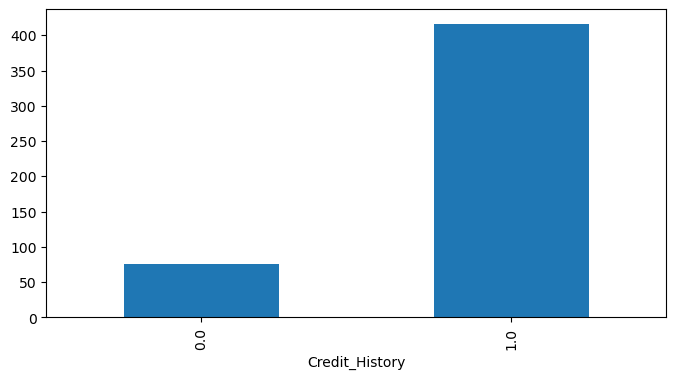

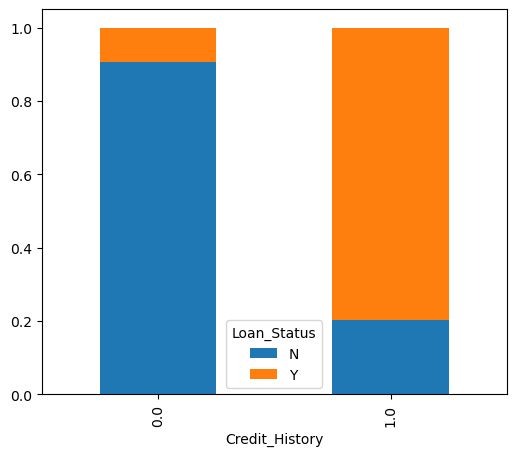

In [78]:
Credit_History = data.groupby('Credit_History')['Credit_History'].count()
Credit_History.plot(kind='bar', figsize=(8, 4))
Credit_History=pd.crosstab(data['Credit_History'],data['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

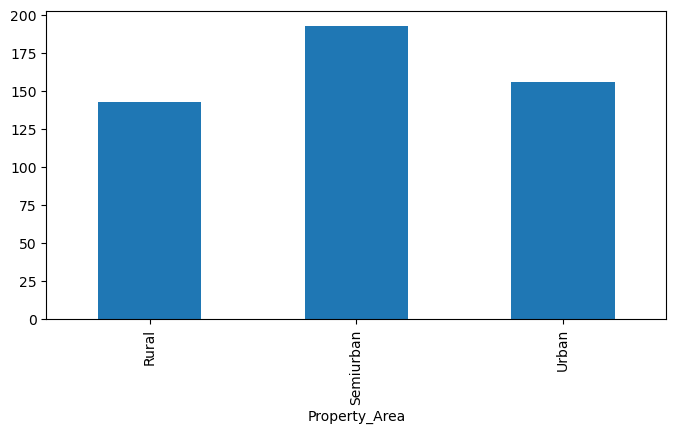

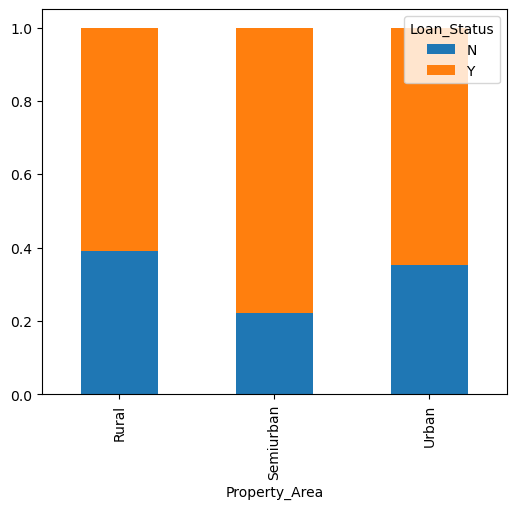

In [79]:
Property_Area = data.groupby('Property_Area')['Property_Area'].count()
Property_Area.plot(kind='bar', figsize=(8, 4))
Property_Area=pd.crosstab(data['Property_Area'],data['Loan_Status'])
Property_Area.div(Property_Area.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,5))
plt.show()

<AxesSubplot:xlabel='Loan_Status'>

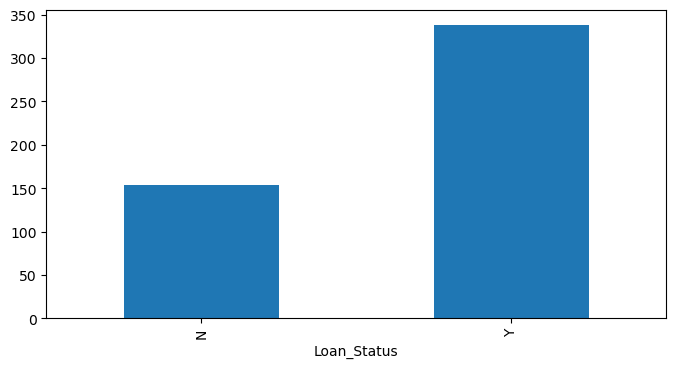

In [80]:
Loan_Status = data.groupby('Loan_Status')['Loan_Status'].count()
Loan_Status.plot(kind='bar', figsize=(8, 4))

### Summarize
Most of the categorial characteristics have approximately equal approval or rejection ratios (the correlation matrix will show more precise ratios later on). The only thing that stands out at the moment is the existence of a compliant credit history.

Let's look at the quantitative data, here we focus on quantiles and plots indicating the type of distribution

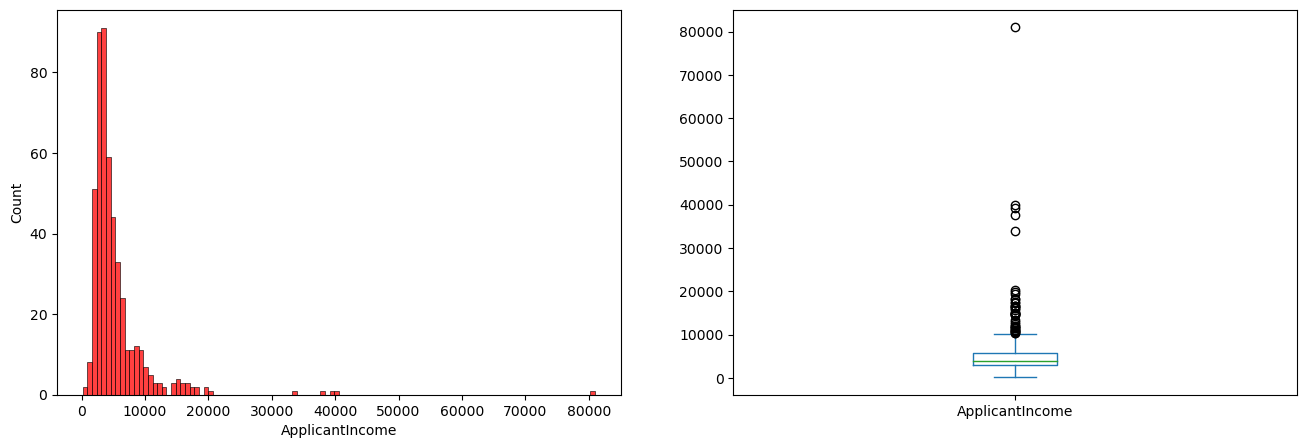

In [81]:
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.histplot(data['ApplicantIncome'],color="r", )

plt.subplot(122)
data['ApplicantIncome'].plot.box(figsize=(16,5))

plt.show()

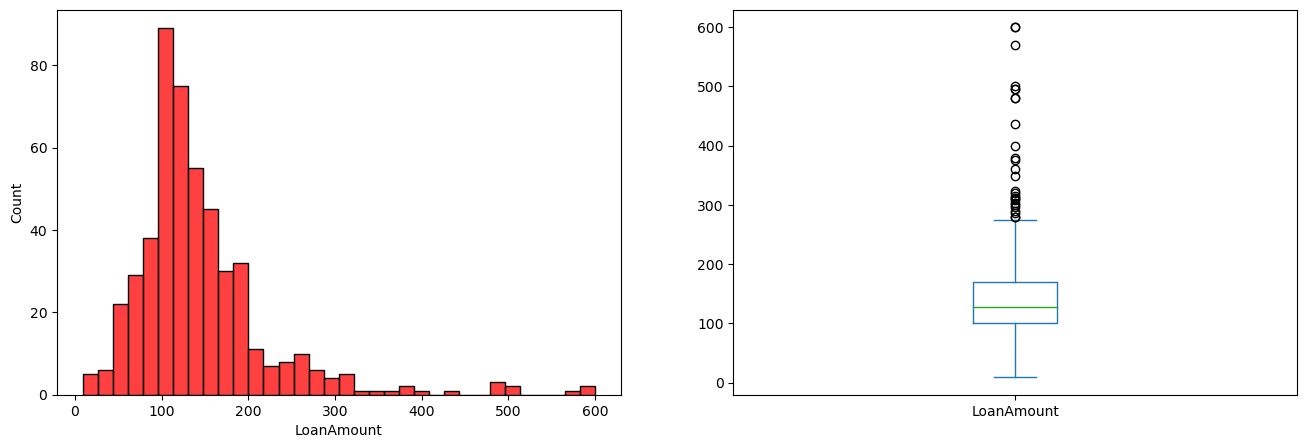

In [82]:
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.histplot(data['LoanAmount'],color="r", )

plt.subplot(122)
data['LoanAmount'].plot.box(figsize=(16,5))

plt.show()

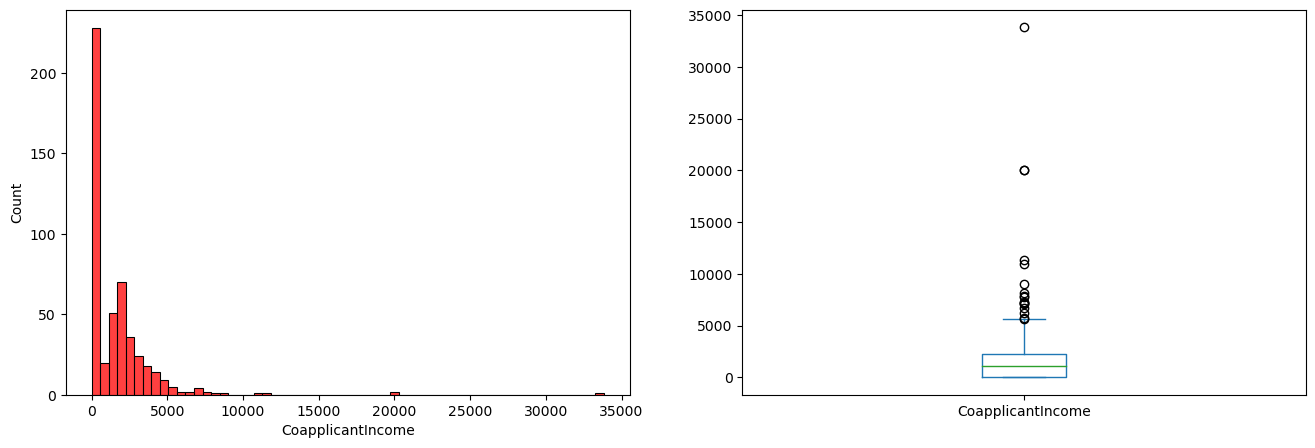

In [83]:
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.histplot(data['CoapplicantIncome'],color="r", )

plt.subplot(122)
data['CoapplicantIncome'].plot.box(figsize=(16,5))

plt.show()

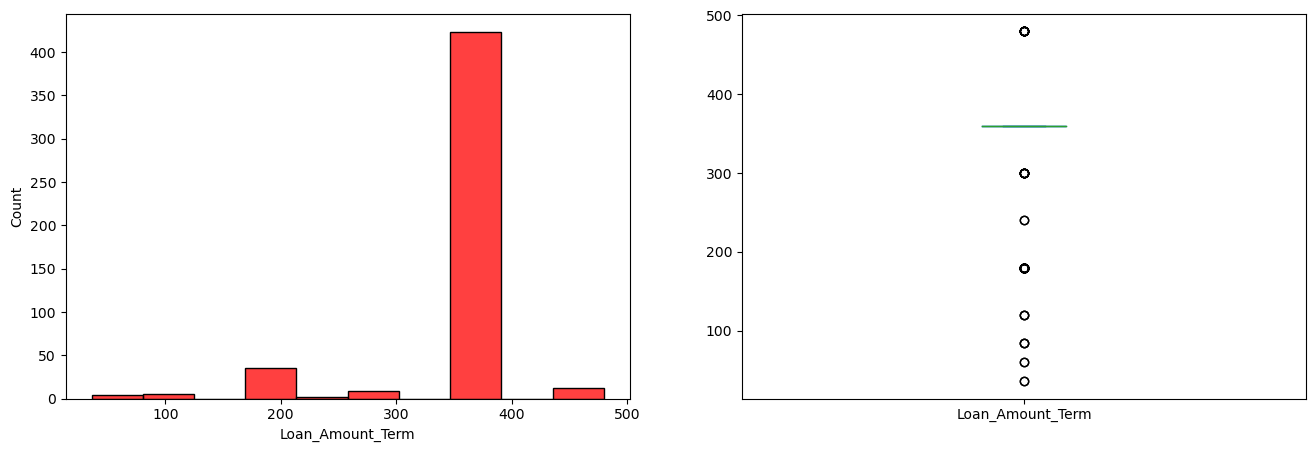

In [84]:
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.histplot(data['Loan_Amount_Term'],color="r", )

plt.subplot(122)
data['Loan_Amount_Term'].plot.box(figsize=(16,5))

plt.show()

### Summarize
As I mentioned earlier Loan_Amount_Term has a brightline score of 360, which greatly overpowers the others. The cold indicators are similar to the Poisson distribution, with small anomalies in the number of co-borrowers with zero income, which is fully explainable by the realities of family life. We also see a significant number of outliers. Perhaps this is my mistake, but I did not remove them in order not to hide the already reduced data.

### Сorrelation matrix
We convert the categorical columns to numeric format, derive correlation matrices separately for categorical and quantitative data as this will give more accurate measures within each species, and then correlations for biserial rank to numeric format

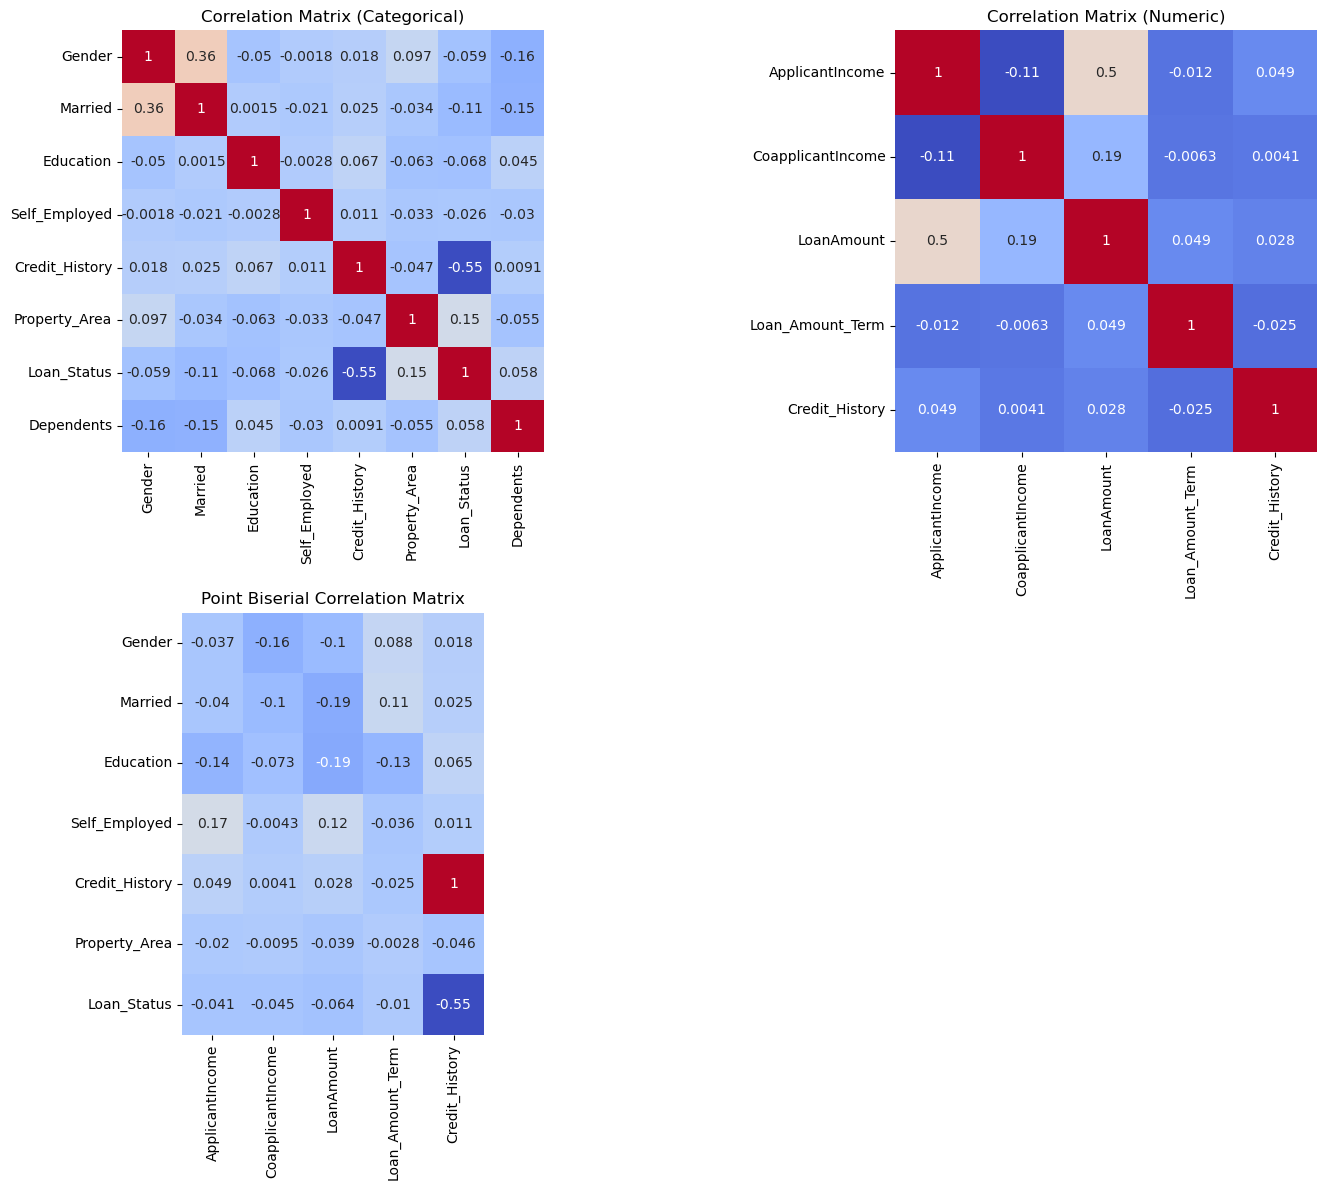

In [85]:
# Convert categorical columns to numeric format
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status', 'Dependents']
for column in categorical_columns:
    data[column] = pd.factorize(data[column])[0]

corr_categorical = data[categorical_columns].corr(method='spearman')
corr_numeric = data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]

#   Convert the correlation matrix for categorical variables to numerical format
corr_categorical = corr_categorical.astype(float)

# Calculate the biserial rank correlation for each pair of categorical and quantitative columns
corr_pointbiserial = pd.DataFrame(index=categorical_columns[:-1], columns=corr_numeric.columns)
for cat_col in categorical_columns[:-1]:
    for num_col in corr_numeric.columns:
        corr, _ = pointbiserialr(data[cat_col], data[num_col])
        corr_pointbiserial.at[cat_col, num_col] = corr

corr_pointbiserial = corr_pointbiserial.astype(float)

# Visualization
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.heatmap(corr_categorical, annot=True, cmap='coolwarm', square=True, cbar=False)
plt.title('Correlation Matrix (Categorical)')

plt.subplot(2, 2, 2)
sns.heatmap(corr_numeric.corr(), annot=True, cmap='coolwarm', square=True, cbar=False)
plt.title('Correlation Matrix (Numeric)')

plt.subplot(2, 2, 3)
sns.heatmap(corr_pointbiserial, annot=True, cmap='coolwarm', square=True, cbar=False)
plt.title('Point Biserial Correlation Matrix')

plt.tight_layout()
plt.show()


### Summarize
We see a correlation between the availability of a suitable credit history and approval, as well as between the amount of credit and income, but none of them is pronounced.

### Machine learning - random forest
While the correlation matrix has given us some data on key feature extraction, I think it is a good idea to refine this information using machine learning, although this is not necessary. The random forest model I think would be the most optimal model to use.

In [93]:
# load original clining data
data = data2

data = pd.get_dummies(data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)
data.drop('Loan_ID', axis=1, inplace=True)
data.fillna(data.median(), inplace=True)

# Splitting the data into attributes (X) and target variable (y)
X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

classification_report_result = classification_report(y_test, y_pred)
print('Classification Report:\n', classification_report_result)


Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.35      0.44        20
           1       0.85      0.94      0.89        79

    accuracy                           0.82        99
   macro avg       0.72      0.64      0.66        99
weighted avg       0.80      0.82      0.80        99



### Summarize
In general, the model has a fairly high accuracy - 82%, which I think will be enough if there are certain disadvantages.

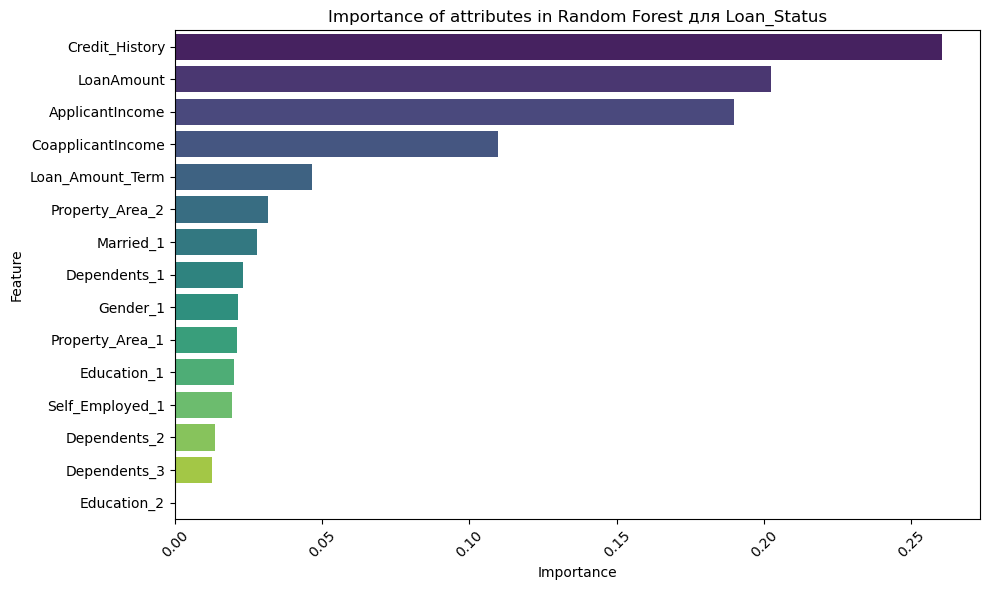

In [94]:
#  Obtaining the importance of traits and their processing
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importance of attributes in Random Forest для Loan_Status')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Summarize
As we can see, credit history still plays a key role, and the amount of credit and income of a potential borrower are also important factors. But the model gives us a reason to add the income of the co-borrower to the list of key factors, although the correlation matrix did not allocate significantly.

### The general conclusion  
The dataset has a significant number of data gaps, many of which cannot be filled in  
The target variable is loan approval  
The credit history that meets the requirements has the greatest impact on loan approval
Secondary factors include the amount of credit and income of a potential borrower,  income of the co-borrower